# Lunds Variables Pair Plot Analysis

This notebook analyzes Lunds variables from a parquet file and creates visualizations including:
- Pair plots of key Lunds variables
- Correlation matrix heatmap
- Data summary statistics

The Lunds variables represent jet substructure observables that are useful for understanding the internal structure of jets in high-energy particle physics.

## Import Required Libraries

Import pandas, numpy, seaborn, matplotlib, and pathlib for data handling and visualization.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from pathlib import Path

# Set matplotlib backend for inline plotting
%matplotlib inline

# Set seaborn style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

## Load Lunds Data from Parquet File

Define and use a function to load Lunds data from a parquet file, flatten the nested structure, and return a DataFrame.

In [2]:
def load_lunds_data(parquet_file):
    """
    Load lunds data from parquet file and extract variables for pair plot
    """
    # Read the parquet file
    df = pd.read_parquet(parquet_file)
    
    # Extract all lunds data into a flat DataFrame
    all_lunds = []
    
    for idx, row in df.iterrows():
        lunds = row['lunds']
        for lund in lunds:
            # Add jet-level information to each lund entry
            lund_entry = lund.copy()
            lund_entry['jet_pt'] = row['pt']
            lund_entry['jet_eta'] = row['eta']
            lund_entry['jet_phi'] = row['phi']
            lund_entry['jet_m'] = row['m']
            lund_entry['label'] = row['label']
            all_lunds.append(lund_entry)
    
    return pd.DataFrame(all_lunds)

# Define the parquet file path
parquet_file = "/Users/ploskon/devel/alian/alian/sandbox/jse/sample_lundjet_1000/lund_jet_hardQCDgluons.parquet"

# Check if file exists
if not Path(parquet_file).exists():
    print(f"Error: File {parquet_file} not found!")
else:
    print("Loading lunds data from parquet file...")
    lunds_df = load_lunds_data(parquet_file)
    print(f"Successfully loaded {len(lunds_df)} lund splittings")

Loading lunds data from parquet file...
Successfully loaded 11183 lund splittings


## Print Data Summary

Print summary statistics of the Lunds data, including counts and variable ranges.

In [3]:
def print_data_summary(lunds_df):
    """
    Print summary statistics of the lunds data
    """
    print("Lunds Data Summary:")
    print(f"Total number of lund splittings: {len(lunds_df)}")
    print(f"Number of jets: {lunds_df['jet_pt'].nunique() if 'jet_pt' in lunds_df.columns else 'Unknown'}")
    
    if 'label' in lunds_df.columns:
        print(f"Labels distribution:")
        print(lunds_df['label'].value_counts().sort_index())
    
    print(f"\nVariable ranges:")
    key_vars = ['delta', 'eta', 'kappa', 'kt', 'm', 'pt', 'z']
    for var in key_vars:
        if var in lunds_df.columns:
            print(f"  {var}: [{lunds_df[var].min():.3e}, {lunds_df[var].max():.3e}]")

# Print data summary
print_data_summary(lunds_df)

Lunds Data Summary:
Total number of lund splittings: 11183
Number of jets: 1114
Labels distribution:
label
2    11183
Name: count, dtype: int64

Variable ranges:
  delta: [3.699e-04, 4.305e-01]
  eta: [-2.125e+00, 2.091e+00]
  kappa: [9.437e-06, 1.834e-01]
  kt: [5.482e-04, 2.177e+01]
  m: [2.342e-03, 3.317e+01]
  pt: [3.993e+00, 1.200e+02]
  z: [7.951e-05, 5.000e-01]


## Create Pair Plot of Lunds Variables

Generate a seaborn pair plot for selected Lunds variables, applying log transforms where appropriate and using hue for labels if available.

Creating pair plot...
Pair plot saved to: lunds_pairplot.png
Pair plot saved to: lunds_pairplot.png


<Figure size 1200x1000 with 0 Axes>

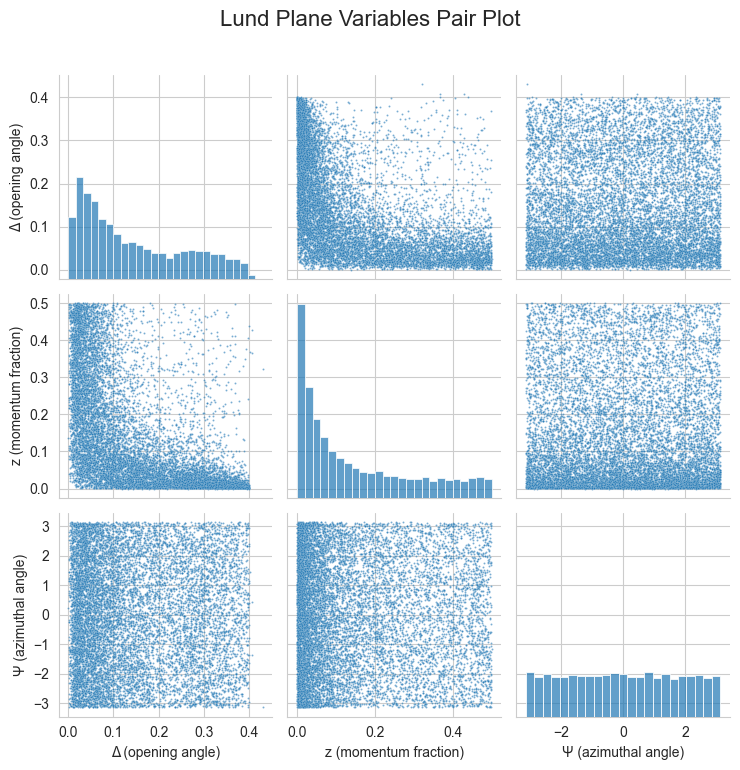

In [4]:
def create_lunds_pairplot(lunds_df, output_file='lunds_pairplot.png'):
    """
    Create seaborn pair plot for lunds variables
    """
    # Select key variables for the pair plot
    # These are the most physically meaningful variables from the lunds splitting
    key_vars = ['delta', 'eta', 'kappa', 'kt', 'm', 'pt', 'z', 'psi']
    
    # Filter the dataframe to only include these variables
    plot_df = lunds_df[key_vars + ['label']].copy()
    
    # Remove any infinite or NaN values
    plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Apply log scale to some variables that have wide dynamic range
    plot_df['log_kt'] = np.log10(plot_df['kt'] + 1e-10)  # Add small constant to avoid log(0)
    plot_df['log_kappa'] = np.log10(plot_df['kappa'] + 1e-10)
    
    # Select final variables for plotting
    # final_vars = ['delta', 'eta', 'log_kappa', 'log_kt', 'm', 'pt', 'z', 'psi']
    final_vars = ['delta', 'z', 'psi']

    # Create the pair plot
    plt.figure(figsize=(12, 10))
    
    # Use hue to color by label if available
    if 'label' in plot_df.columns and plot_df['label'].nunique() > 1:
        g = sns.pairplot(plot_df[final_vars + ['label']], 
                        hue='label',
                        diag_kind='hist',
                        plot_kws={'alpha': 0.6, 's': 2},
                        diag_kws={'alpha': 0.7})
    else:
        g = sns.pairplot(plot_df[final_vars], 
                        diag_kind='hist',
                        plot_kws={'alpha': 0.6, 's': 2},
                        diag_kws={'alpha': 0.7})
    
    # Customize the plot
    g.fig.suptitle('Lund Plane Variables Pair Plot', y=1.02, fontsize=16)
    
    # Add variable descriptions as axis labels
    var_labels = {
        'delta': 'Δ (opening angle)',
        'eta': 'η (pseudorapidity)', 
        'log_kappa': 'log(κ)',
        'log_kt': 'log(kT)',
        'm': 'mass',
        'pt': 'pT',
        'z': 'z (momentum fraction)',
        'psi': 'Ψ (azimuthal angle)'
    }
    
    # Update axis labels
    for i, ax_row in enumerate(g.axes):
        for j, ax in enumerate(ax_row):
            if i == len(g.axes) - 1:  # Bottom row
                ax.set_xlabel(var_labels.get(final_vars[j], final_vars[j]))
            if j == 0:  # Left column
                ax.set_ylabel(var_labels.get(final_vars[i], final_vars[i]))
    
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Pair plot saved to: {output_file}")
    
    return g

# Create the pair plot
print("Creating pair plot...")
g = create_lunds_pairplot(lunds_df)
plt.show()

## Create Correlation Matrix Plot

Compute and visualize the correlation matrix of the selected (and log-transformed) Lunds variables using seaborn's heatmap.

Creating correlation matrix...
Correlation matrix saved to: lunds_correlation_matrix.png
Correlation matrix saved to: lunds_correlation_matrix.png


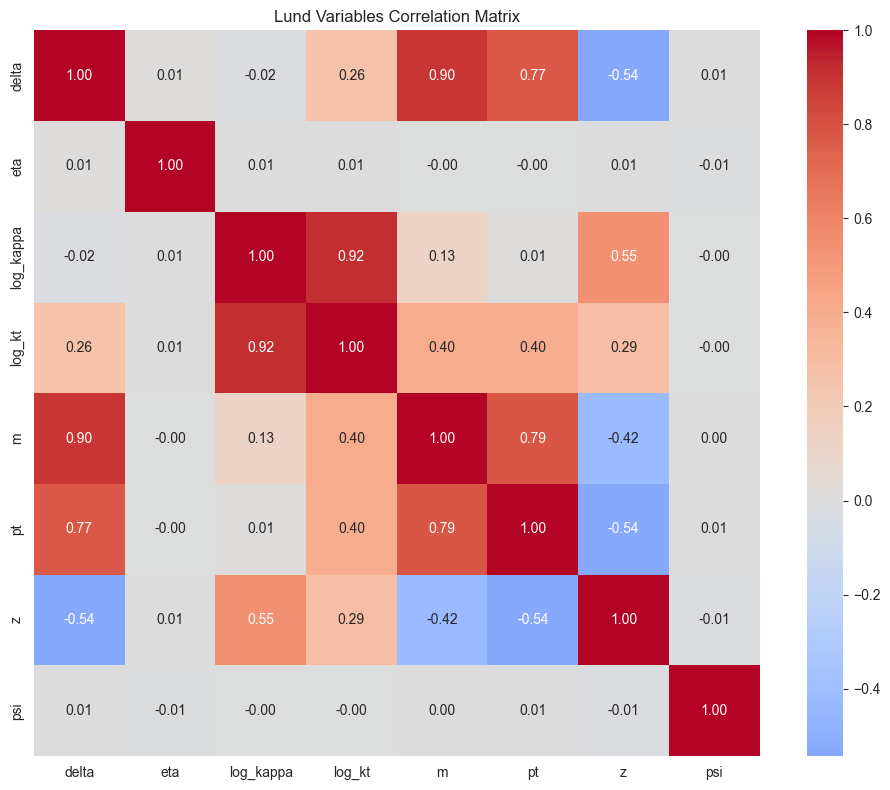

In [5]:
# Create correlation matrix plot
print("Creating correlation matrix...")

key_vars = ['delta', 'eta', 'kappa', 'kt', 'm', 'pt', 'z', 'psi']
corr_data = lunds_df[key_vars].copy()
corr_data['log_kt'] = np.log10(corr_data['kt'] + 1e-10)
corr_data['log_kappa'] = np.log10(corr_data['kappa'] + 1e-10)

plt.figure(figsize=(10, 8))
correlation_matrix = corr_data[['delta', 'eta', 'log_kappa', 'log_kt', 'm', 'pt', 'z', 'psi']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f')
plt.title('Lund Variables Correlation Matrix')
plt.tight_layout()
plt.savefig('lunds_correlation_matrix.png', dpi=300, bbox_inches='tight')
print("Correlation matrix saved to: lunds_correlation_matrix.png")
plt.show()

## Analyze Correlations in Subsequent Splittings

Investigate how variables in consecutive Lunds splittings are correlated within the same jet. This analysis looks at the relationship between splitting variables at different levels of the jet clustering hierarchy.

In [6]:
def analyze_subsequent_splitting_correlations(parquet_file):
    """
    Analyze correlations between consecutive splitting variables within the same jet
    """
    # Read the original parquet file to maintain jet structure
    df = pd.read_parquet(parquet_file)
    
    # Variables to analyze
    variables = ['delta', 'eta', 'kappa', 'kt', 'm', 'pt', 'z', 'psi']
    
    # Store correlations for each variable pair
    correlations = {}
    n_pairs = 0
    
    # Process each jet
    for idx, row in df.iterrows():
        lunds = row['lunds']
        
        # Need at least 2 splittings to compute correlations
        if len(lunds) < 2:
            continue
            
        # Compare consecutive splittings
        for i in range(len(lunds) - 1):
            current_split = lunds[i]
            next_split = lunds[i + 1]
            
            # Extract variables for both splittings
            for var in variables:
                if var in current_split and var in next_split:
                    key = f"{var}_correlation"
                    if key not in correlations:
                        correlations[key] = {'current': [], 'next': []}
                    
                    correlations[key]['current'].append(current_split[var])
                    correlations[key]['next'].append(next_split[var])
            
            n_pairs += 1
    
    print(f"Analyzed {n_pairs} pairs of consecutive splittings from {len(df)} jets")
    
    # Calculate correlation coefficients
    correlation_results = {}
    for var in variables:
        key = f"{var}_correlation"
        if key in correlations and len(correlations[key]['current']) > 1:
            current_vals = np.array(correlations[key]['current'])
            next_vals = np.array(correlations[key]['next'])
            
            # Remove infinite and NaN values
            mask = np.isfinite(current_vals) & np.isfinite(next_vals)
            if np.sum(mask) > 1:
                corr_coef = np.corrcoef(current_vals[mask], next_vals[mask])[0, 1]
                correlation_results[var] = {
                    'correlation': corr_coef,
                    'n_pairs': np.sum(mask),
                    'current_vals': current_vals[mask],
                    'next_vals': next_vals[mask]
                }
    
    return correlation_results

# Analyze subsequent splitting correlations
corr_results = analyze_subsequent_splitting_correlations(parquet_file)

# Display results
print("\nCorrelation between consecutive splittings:")
print("=" * 50)
for var, results in corr_results.items():
    print(f"{var:>8}: r = {results['correlation']:6.3f} (n = {results['n_pairs']:,})")

Analyzed 10069 pairs of consecutive splittings from 1114 jets

Correlation between consecutive splittings:
   delta: r =  0.959 (n = 10,069)
     eta: r =  1.000 (n = 10,069)
   kappa: r =  0.099 (n = 10,069)
      kt: r =  0.052 (n = 10,069)
       m: r =  0.927 (n = 10,069)
      pt: r =  0.950 (n = 10,069)
       z: r =  0.327 (n = 10,069)
     psi: r = -0.160 (n = 10,069)


Subsequent splitting correlations plot saved to: subsequent_splitting_correlations.png


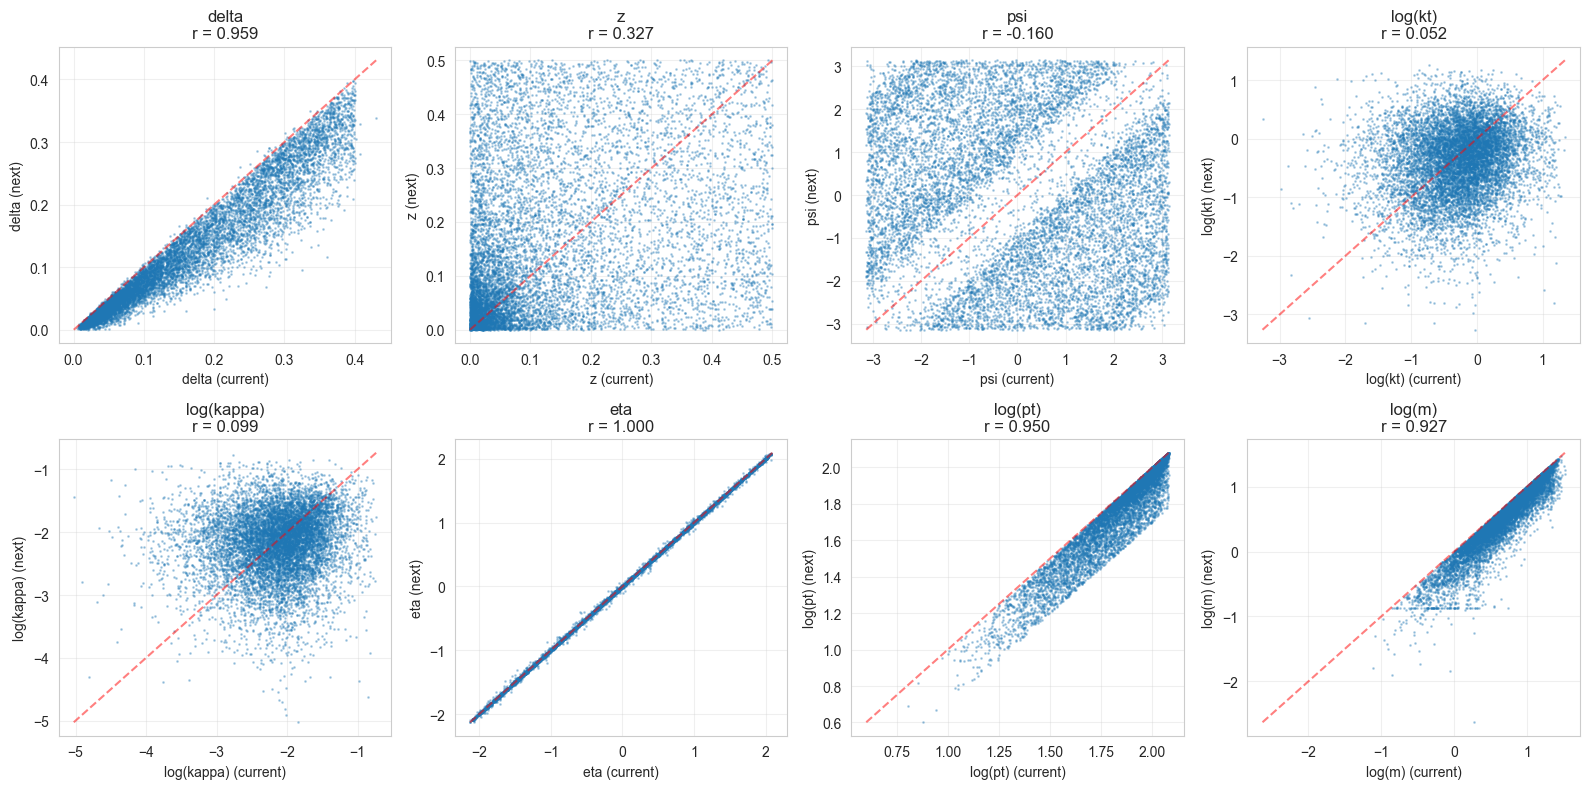

In [7]:
# Visualize correlations between subsequent splittings
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

plot_vars = ['delta', 'z', 'psi', 'kt', 'kappa', 'eta', 'pt', 'm']

for i, var in enumerate(plot_vars):
    if i < len(axes) and var in corr_results:
        ax = axes[i]
        current_vals = corr_results[var]['current_vals']
        next_vals = corr_results[var]['next_vals']
        
        # Apply log scale for variables with wide dynamic range
        if var in ['kt', 'kappa', 'pt', 'm']:
            current_vals = np.log10(current_vals + 1e-10)
            next_vals = np.log10(next_vals + 1e-10)
            var_label = f'log({var})'
        else:
            var_label = var
        
        # Create scatter plot
        ax.scatter(current_vals, next_vals, alpha=0.3, s=1)
        
        # Add correlation coefficient to plot
        r = corr_results[var]['correlation']
        ax.set_title(f'{var_label}\nr = {r:.3f}')
        ax.set_xlabel(f'{var_label} (current)')
        ax.set_ylabel(f'{var_label} (next)')
        
        # Add diagonal line for reference
        min_val = min(np.min(current_vals), np.min(next_vals))
        max_val = max(np.max(current_vals), np.max(next_vals))
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
        
        ax.grid(True, alpha=0.3)
    else:
        if i < len(axes):
            axes[i].set_visible(False)

plt.tight_layout()
plt.savefig('subsequent_splitting_correlations.png', dpi=300, bbox_inches='tight')
print("Subsequent splitting correlations plot saved to: subsequent_splitting_correlations.png")
plt.show()

Splitting depth correlations plot saved to: splitting_depth_correlations.png


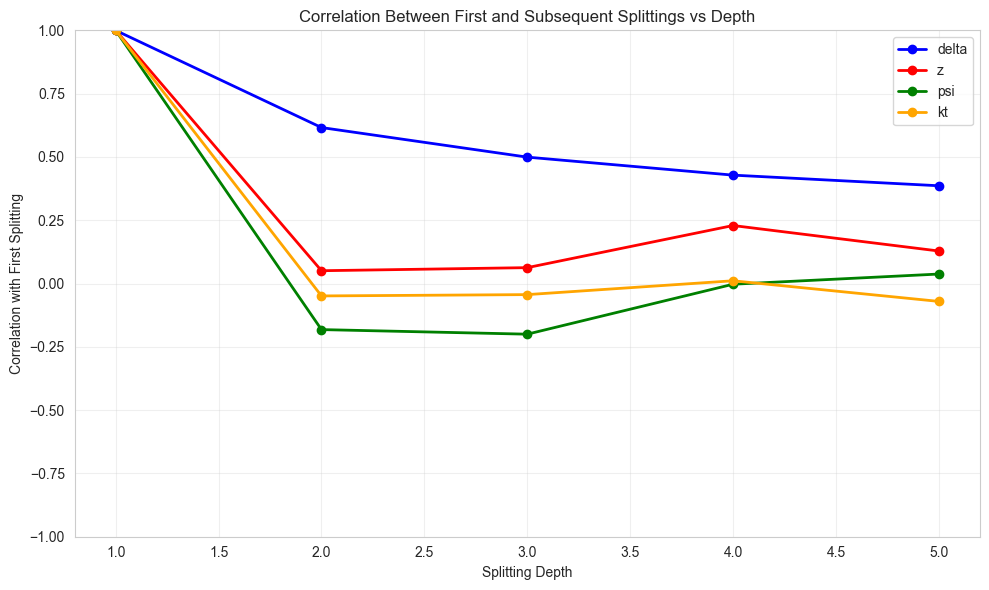


Correlation with first splitting by depth:
Depth  delta    z        psi      kt      
------------------------------------------------------------
1        1.000   1.000   1.000   1.000
2        0.616   0.051  -0.182  -0.049
3        0.499   0.063  -0.200  -0.044
4        0.428   0.229  -0.003   0.011
5        0.386   0.129   0.038  -0.070


In [8]:
# Analyze how correlations change with splitting depth
def analyze_splitting_depth_correlations(parquet_file, max_depth=5):
    """
    Analyze how variable correlations change as a function of splitting depth
    """
    df = pd.read_parquet(parquet_file)
    
    # Track correlations by depth
    depth_correlations = {}
    
    for depth in range(1, max_depth + 1):
        depth_correlations[depth] = {}
        
        # Collect data for jets with at least 'depth' splittings
        for idx, row in df.iterrows():
            lunds = row['lunds']
            
            if len(lunds) >= depth:
                # Compare splitting at depth 0 with splitting at specified depth
                first_split = lunds[0]
                depth_split = lunds[depth - 1]
                
                for var in ['delta', 'z', 'psi', 'kt']:
                    if var in first_split and var in depth_split:
                        if var not in depth_correlations[depth]:
                            depth_correlations[depth][var] = {'first': [], 'depth': []}
                        
                        depth_correlations[depth][var]['first'].append(first_split[var])
                        depth_correlations[depth][var]['depth'].append(depth_split[var])
    
    # Calculate correlation coefficients
    depth_results = {}
    for depth in range(1, max_depth + 1):
        depth_results[depth] = {}
        for var in ['delta', 'z', 'psi', 'kt']:
            if var in depth_correlations[depth] and len(depth_correlations[depth][var]['first']) > 1:
                first_vals = np.array(depth_correlations[depth][var]['first'])
                depth_vals = np.array(depth_correlations[depth][var]['depth'])
                
                # Remove infinite and NaN values
                mask = np.isfinite(first_vals) & np.isfinite(depth_vals)
                if np.sum(mask) > 1:
                    corr_coef = np.corrcoef(first_vals[mask], depth_vals[mask])[0, 1]
                    depth_results[depth][var] = {
                        'correlation': corr_coef,
                        'n_pairs': np.sum(mask)
                    }
    
    return depth_results

# Analyze depth correlations
depth_results = analyze_splitting_depth_correlations(parquet_file)

# Plot correlation vs depth
fig, ax = plt.subplots(figsize=(10, 6))

variables = ['delta', 'z', 'psi', 'kt']
colors = ['blue', 'red', 'green', 'orange']

for i, var in enumerate(variables):
    depths = []
    correlations = []
    
    for depth in depth_results:
        if var in depth_results[depth]:
            depths.append(depth)
            correlations.append(depth_results[depth][var]['correlation'])
    
    if depths:
        ax.plot(depths, correlations, 'o-', color=colors[i], label=var, linewidth=2, markersize=6)

ax.set_xlabel('Splitting Depth')
ax.set_ylabel('Correlation with First Splitting')
ax.set_title('Correlation Between First and Subsequent Splittings vs Depth')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_ylim(-1, 1)

plt.tight_layout()
plt.savefig('splitting_depth_correlations.png', dpi=300, bbox_inches='tight')
print("Splitting depth correlations plot saved to: splitting_depth_correlations.png")
plt.show()

# Print numerical results
print("\nCorrelation with first splitting by depth:")
print("=" * 60)
print(f"{'Depth':<6} {'delta':<8} {'z':<8} {'psi':<8} {'kt':<8}")
print("-" * 60)
for depth in sorted(depth_results.keys()):
    line = f"{depth:<6}"
    for var in variables:
        if var in depth_results[depth]:
            corr = depth_results[depth][var]['correlation']
            line += f"{corr:8.3f}"
        else:
            line += f"{'---':<8}"
    print(line)

## Analyze Splitting Evolution with 2D Heatmap

Investigate how splittings evolve by analyzing the differences in delta and kt between the highest kt splitting and other splittings in the same jet. This provides insight into the jet substructure hierarchy.

In [9]:
def analyze_splitting_evolution_heatmap(parquet_file):
    """
    Analyze splitting evolution by comparing each splitting with the highest kt splitting
    Creates 2D heatmap with:
    - x-axis: delta_i - delta_highest_kt
    - y-axis: kt_i - kt_highest_kt
    """
    # Read the original parquet file to maintain jet structure
    df = pd.read_parquet(parquet_file)
    
    # Store differences for heatmap
    delta_diffs = []
    kt_diffs = []
    
    jets_analyzed = 0
    total_splittings = 0
    
    # Process each jet
    for idx, row in df.iterrows():
        lunds = row['lunds']
        
        # Need at least 2 splittings
        if len(lunds) < 2:
            continue
            
        jets_analyzed += 1
        
        # Find the splitting with highest kt
        kt_values = [split.get('kt', 0) for split in lunds]
        highest_kt_idx = np.argmax(kt_values)
        highest_kt_split = lunds[highest_kt_idx]
        
        # Get reference values
        ref_delta = highest_kt_split.get('delta', np.nan)
        ref_kt = highest_kt_split.get('kt', np.nan)
        
        if np.isnan(ref_delta) or np.isnan(ref_kt):
            continue
        
        # Compare all other splittings to the highest kt splitting
        for i, split in enumerate(lunds):
            if i == highest_kt_idx:  # Skip the reference splitting itself
                continue
                
            delta_i = split.get('delta', np.nan)
            kt_i = split.get('kt', np.nan)
            
            if not (np.isnan(delta_i) or np.isnan(kt_i)):
                delta_diff = delta_i - ref_delta
                kt_diff = kt_i - ref_kt
                
                delta_diffs.append(delta_diff)
                kt_diffs.append(kt_diff)
                total_splittings += 1
    
    print(f"Analyzed {jets_analyzed} jets with {total_splittings} splitting comparisons")
    
    return np.array(delta_diffs), np.array(kt_diffs)

# Analyze splitting evolution
print("Analyzing splitting evolution...")
delta_diffs, kt_diffs = analyze_splitting_evolution_heatmap(parquet_file)

print(f"Delta differences range: [{np.min(delta_diffs):.3f}, {np.max(delta_diffs):.3f}]")
print(f"kt differences range: [{np.min(kt_diffs):.3e}, {np.max(kt_diffs):.3e}]")

Analyzing splitting evolution...
Analyzed 1114 jets with 10069 splitting comparisons
Delta differences range: [-0.390, 0.363]
kt differences range: [-2.177e+01, -7.323e-04]


## Primary Lund Plane Density Analysis

Create a density plot of the primary Lund Plane using only two selected splittings from each jet. This analysis focuses on the most significant splittings rather than all splittings in the jet.

In [13]:
def extract_primary_lund_splittings(parquet_file, selection_method='highest_kt'):
    """
    Extract two selected splittings from each jet for primary Lund Plane analysis
    
    Parameters:
    - selection_method: 'highest_kt' (highest and second highest kt),
                       'first_two' (first two splittings),
                       'hardest_widest' (highest kt and widest delta)
    """
    # Read the original parquet file to maintain jet structure
    df = pd.read_parquet(parquet_file)
    
    selected_splittings = []
    jets_processed = 0
    
    for idx, row in df.iterrows():
        lunds = row['lunds']
        
        # Need at least 2 splittings
        if len(lunds) < 2:
            continue
            
        jets_processed += 1
        
        if selection_method == 'highest_kt':
            # Select the two splittings with highest kt
            kt_values = [(i, split.get('kt', 0)) for i, split in enumerate(lunds)]
            kt_values.sort(key=lambda x: x[1], reverse=True)
            selected_indices = [kt_values[0][0], kt_values[1][0]]
            
        elif selection_method == 'first_two':
            # Select the first two splittings
            selected_indices = [0, 1]
            
        elif selection_method == 'hardest_widest':
            # Select highest kt and widest delta
            kt_values = [(i, split.get('kt', 0)) for i, split in enumerate(lunds)]
            delta_values = [(i, split.get('delta', 0)) for i, split in enumerate(lunds)]
            
            hardest_idx = max(kt_values, key=lambda x: x[1])[0]
            widest_idx = max(delta_values, key=lambda x: x[1])[0]
            
            # If they're the same, take the second highest kt
            if hardest_idx == widest_idx:
                kt_values.sort(key=lambda x: x[1], reverse=True)
                selected_indices = [kt_values[0][0], kt_values[1][0]]
            else:
                selected_indices = [hardest_idx, widest_idx]
        
        # Extract the selected splittings
        for split_idx in selected_indices:
            split = lunds[split_idx]
            
            # Add jet-level information and splitting order
            split_data = split.copy()
            split_data['jet_pt'] = row['pt']
            split_data['jet_eta'] = row['eta']
            split_data['jet_phi'] = row['phi']
            split_data['jet_m'] = row['m']
            split_data['label'] = row['label']
            split_data['jet_id'] = idx
            split_data['splitting_order'] = split_idx
            split_data['selection_rank'] = selected_indices.index(split_idx) + 1
            
            selected_splittings.append(split_data)
    
    print(f"Processed {jets_processed} jets, extracted {len(selected_splittings)} selected splittings")
    
    return pd.DataFrame(selected_splittings)

# Extract primary splittings using different methods
print("Extracting primary splittings using highest kt method...")
primary_df_kt = extract_primary_lund_splittings(parquet_file, 'highest_kt')

print("Extracting primary splittings using first two method...")
primary_df_first = extract_primary_lund_splittings(parquet_file, 'first_two')

print("Extracting primary splittings using hardest-widest method...")
primary_df_hw = extract_primary_lund_splittings(parquet_file, 'hardest_widest')

Extracting primary splittings using highest kt method...
Processed 1114 jets, extracted 2228 selected splittings
Extracting primary splittings using first two method...
Processed 1114 jets, extracted 2228 selected splittings
Extracting primary splittings using hardest-widest method...
Processed 1114 jets, extracted 2228 selected splittings


\n============================================================
Creating Primary Lund Plane Density Plots
Using 2228 valid splittings for Highest kt Splittings
log(1/delta) range: [0.84, 4.19]
log(k_T) range: [-1.19, 3.08]
Using 2228 valid splittings for Highest kt Splittings
log(1/delta) range: [0.84, 4.19]
log(k_T) range: [-1.19, 3.08]
Primary Lund Plane plot saved to: primary_lund_plane_highest_kt_splittings.png
Primary Lund Plane plot saved to: primary_lund_plane_highest_kt_splittings.png


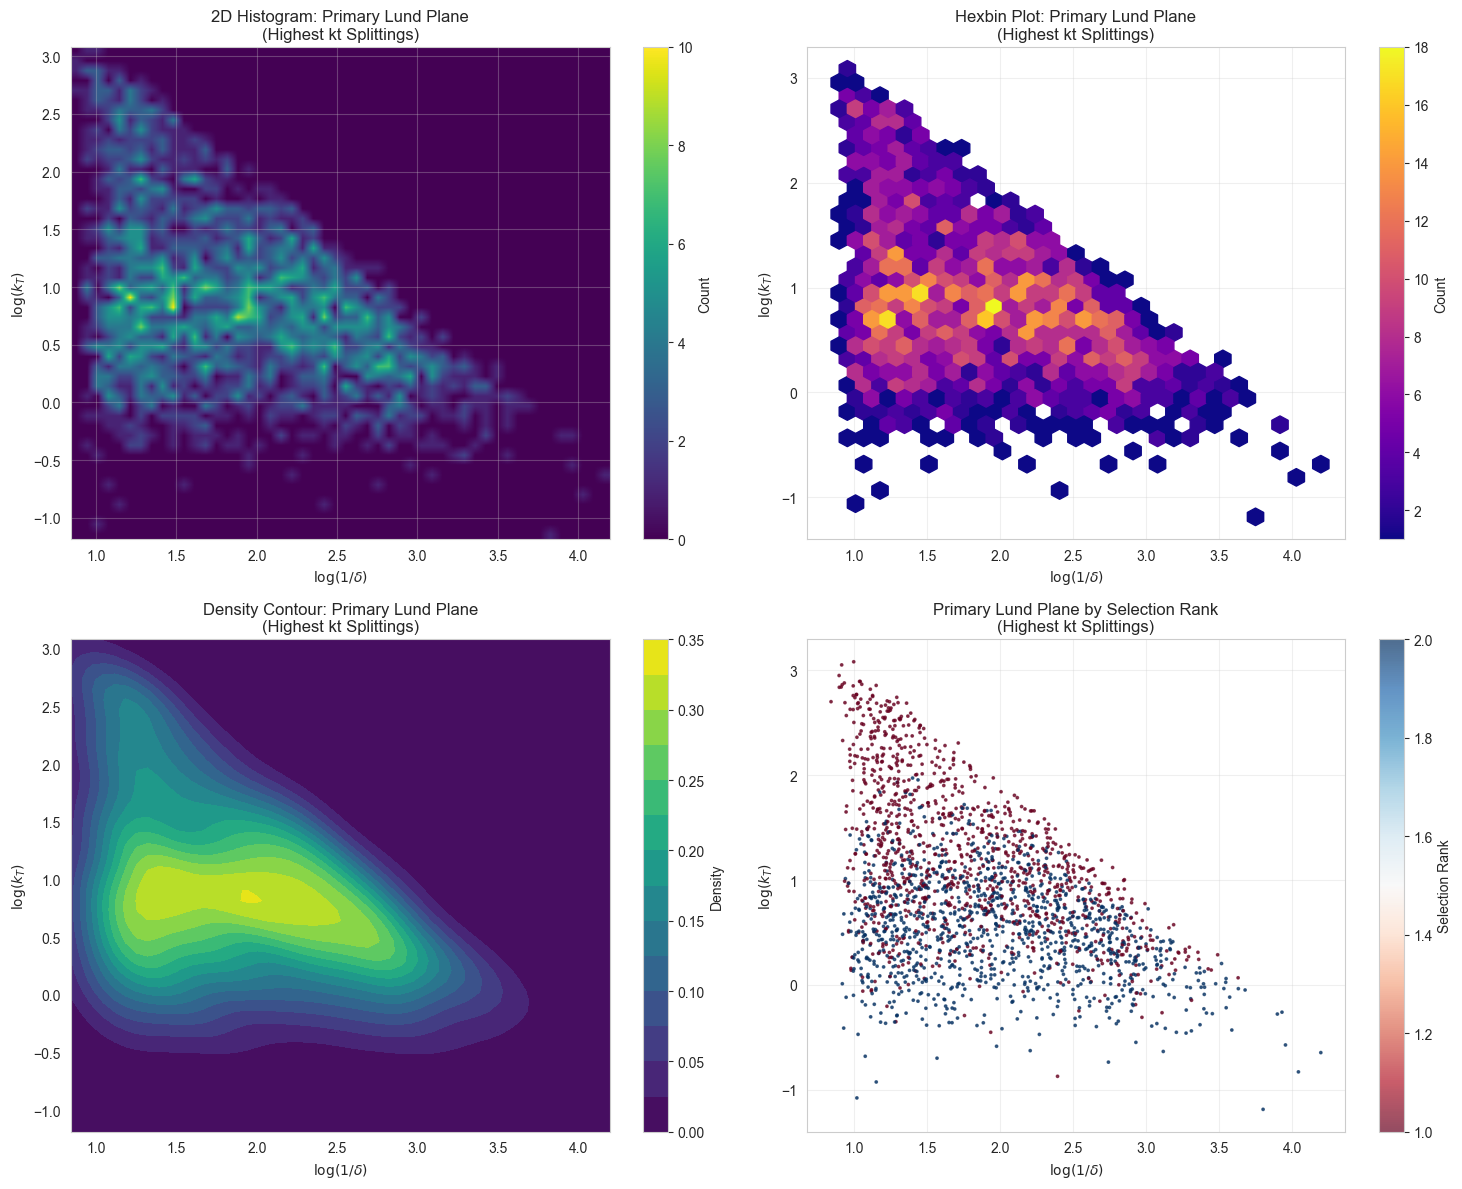

In [14]:
def create_primary_lund_plane_density(primary_df, method_name, output_file=None):
    """
    Create density plot of the primary Lund Plane
    The Lund plane uses log(1/delta) vs log(kt)
    """
    # Calculate Lund plane coordinates
    # Remove infinite and NaN values first
    valid_mask = (
        np.isfinite(primary_df['delta']) & 
        np.isfinite(primary_df['kt']) & 
        (primary_df['delta'] > 0) & 
        (primary_df['kt'] > 0)
    )
    
    filtered_df = primary_df[valid_mask].copy()
    
    # Calculate Lund plane coordinates
    lund_x = np.log(1.0 / filtered_df['delta'])  # log(1/delta)
    lund_y = np.log(filtered_df['kt'])           # log(kt)
    
    print(f"Using {len(filtered_df)} valid splittings for {method_name}")
    print(f"log(1/delta) range: [{np.min(lund_x):.2f}, {np.max(lund_x):.2f}]")
    print(f"log(k_T) range: [{np.min(lund_y):.2f}, {np.max(lund_y):.2f}]")
    
    # Create the figure with multiple visualization methods
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 2D histogram
    h, xedges, yedges = np.histogram2d(lund_x, lund_y, bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    im1 = axes[0, 0].imshow(h.T, origin='lower', extent=extent, aspect='auto', 
                           cmap='viridis', interpolation='bilinear')
    axes[0, 0].set_xlabel(r'$\log(1/\delta)$')
    axes[0, 0].set_ylabel(r'$\log(k_T)$')
    axes[0, 0].set_title(f'2D Histogram: Primary Lund Plane\n({method_name})')
    axes[0, 0].grid(True, alpha=0.3)
    plt.colorbar(im1, ax=axes[0, 0], label='Count')
    
    # Hexbin plot
    hb = axes[0, 1].hexbin(lund_x, lund_y, gridsize=30, cmap='plasma', mincnt=1)
    axes[0, 1].set_xlabel(r'$\log(1/\delta)$')
    axes[0, 1].set_ylabel(r'$\log(k_T)$')
    axes[0, 1].set_title(f'Hexbin Plot: Primary Lund Plane\n({method_name})')
    axes[0, 1].grid(True, alpha=0.3)
    plt.colorbar(hb, ax=axes[0, 1], label='Count')
    
    # Density contour plot
    from scipy.stats import gaussian_kde
    
    # Create a grid for contour plotting
    x_min, x_max = np.min(lund_x), np.max(lund_x)
    y_min, y_max = np.min(lund_y), np.max(lund_y)
    
    # Create a subset for KDE (to avoid memory issues with large datasets)
    n_kde = min(5000, len(lund_x))
    kde_indices = np.random.choice(len(lund_x), n_kde, replace=False)
    kde_x = lund_x.iloc[kde_indices] if hasattr(lund_x, 'iloc') else lund_x[kde_indices]
    kde_y = lund_y.iloc[kde_indices] if hasattr(lund_y, 'iloc') else lund_y[kde_indices]
    
    try:
        kde = gaussian_kde([kde_x, kde_y])
        xi = np.linspace(x_min, x_max, 50)
        yi = np.linspace(y_min, y_max, 50)
        xi_grid, yi_grid = np.meshgrid(xi, yi)
        zi = kde(np.vstack([xi_grid.ravel(), yi_grid.ravel()]))
        zi = zi.reshape(xi_grid.shape)
        
        contour = axes[1, 0].contourf(xi_grid, yi_grid, zi, levels=15, cmap='viridis')
        axes[1, 0].set_xlabel(r'$\log(1/\delta)$')
        axes[1, 0].set_ylabel(r'$\log(k_T)$')
        axes[1, 0].set_title(f'Density Contour: Primary Lund Plane\n({method_name})')
        axes[1, 0].grid(True, alpha=0.3)
        plt.colorbar(contour, ax=axes[1, 0], label='Density')
    except:
        # Fallback to scatter plot if KDE fails
        axes[1, 0].scatter(lund_x, lund_y, alpha=0.5, s=1)
        axes[1, 0].set_xlabel(r'$\log(1/\delta)$')
        axes[1, 0].set_ylabel(r'$\log(k_T)$')
        axes[1, 0].set_title(f'Scatter Plot: Primary Lund Plane\n({method_name})')
        axes[1, 0].grid(True, alpha=0.3)
    
    # Scatter plot colored by selection rank
    if 'selection_rank' in filtered_df.columns:
        scatter = axes[1, 1].scatter(lund_x, lund_y, 
                                   c=filtered_df['selection_rank'], 
                                   cmap='RdBu', alpha=0.7, s=3)
        axes[1, 1].set_xlabel(r'$\log(1/\delta)$')
        axes[1, 1].set_ylabel(r'$\log(k_T)$')
        axes[1, 1].set_title(f'Primary Lund Plane by Selection Rank\n({method_name})')
        axes[1, 1].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[1, 1], label='Selection Rank')
    else:
        axes[1, 1].scatter(lund_x, lund_y, alpha=0.5, s=1)
        axes[1, 1].set_xlabel(r'$\log(1/\delta)$')
        axes[1, 1].set_ylabel(r'$\log(k_T)$')
        axes[1, 1].set_title(f'Scatter Plot: Primary Lund Plane\n({method_name})')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if output_file is None:
        output_file = f'primary_lund_plane_{method_name.lower().replace(" ", "_").replace("-", "_")}.png'
    
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Primary Lund Plane plot saved to: {output_file}")
    
    return fig, (lund_x, lund_y)

# Create primary Lund Plane density plots for different selection methods
print("\\n" + "="*60)
print("Creating Primary Lund Plane Density Plots")
print("="*60)

# Highest kt method
fig1, (lund_x_kt, lund_y_kt) = create_primary_lund_plane_density(
    primary_df_kt, "Highest kt Splittings"
)
plt.show()

Using 2228 valid splittings for First Two Splittings
log(1/delta) range: [0.84, 2.15]
log(k_T) range: [-6.45, 3.08]
Primary Lund Plane plot saved to: primary_lund_plane_first_two_splittings.png
Primary Lund Plane plot saved to: primary_lund_plane_first_two_splittings.png


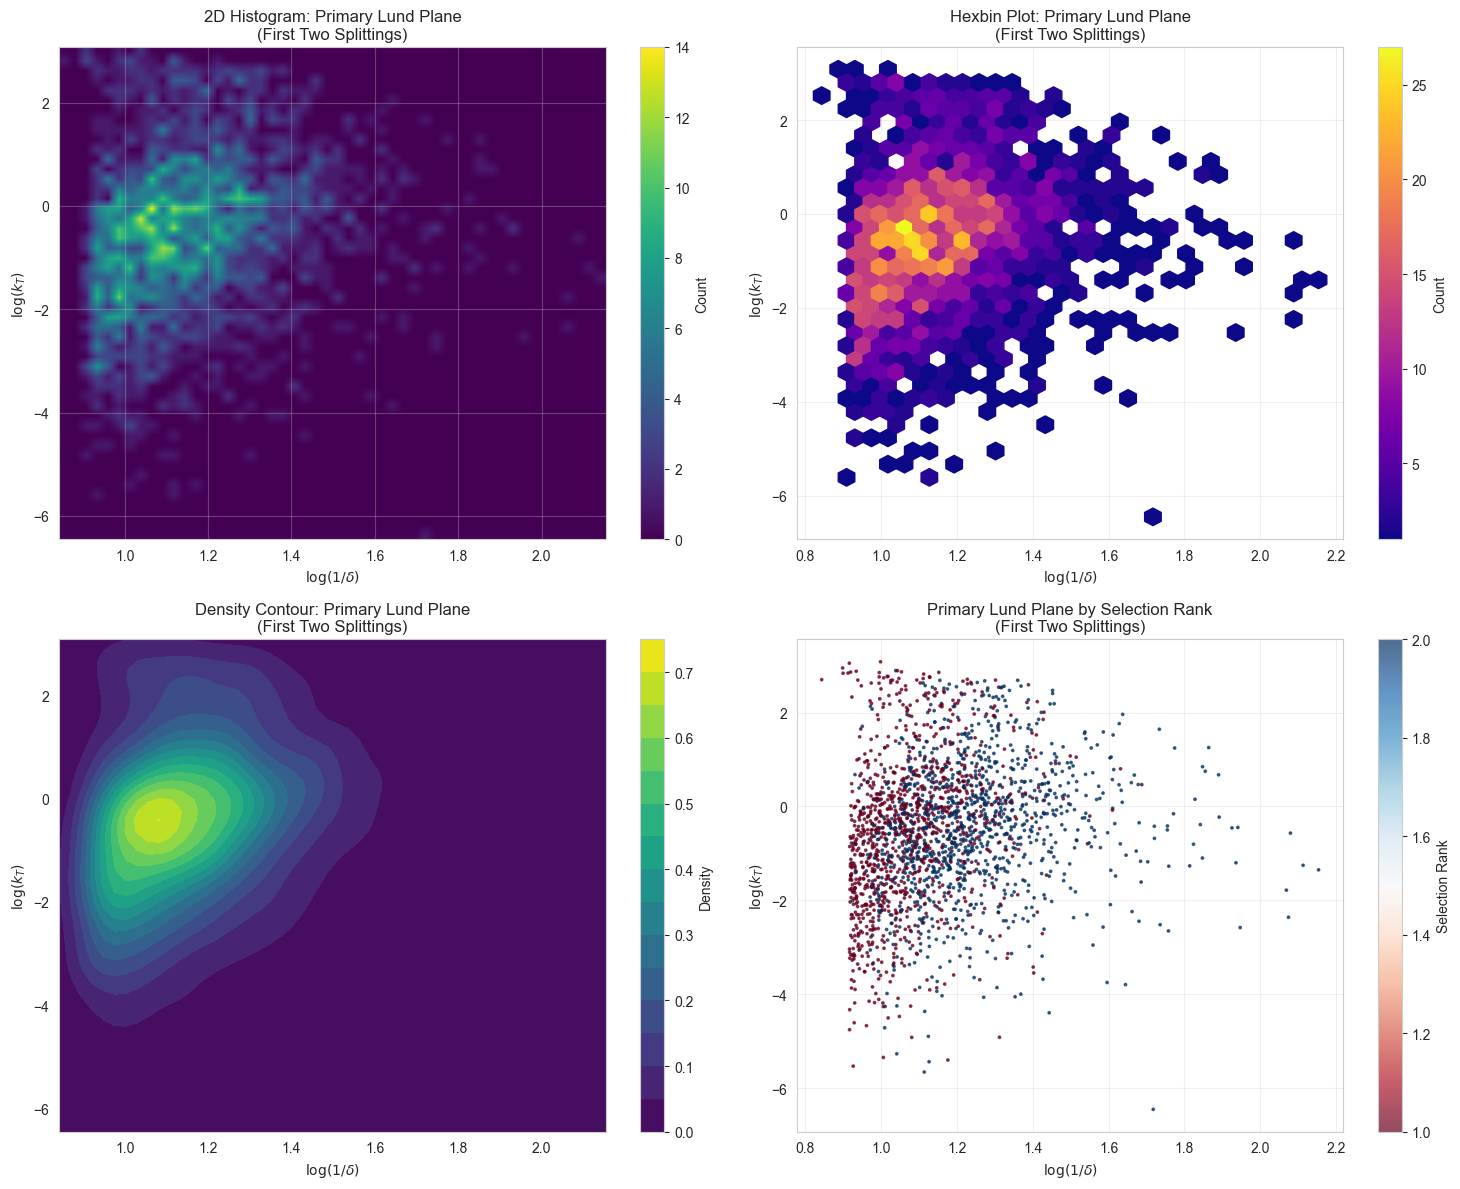

Using 2228 valid splittings for Hardest-Widest Splittings
log(1/delta) range: [0.84, 4.19]
log(k_T) range: [-5.53, 3.08]
Primary Lund Plane plot saved to: primary_lund_plane_hardest_widest_splittings.png
Primary Lund Plane plot saved to: primary_lund_plane_hardest_widest_splittings.png


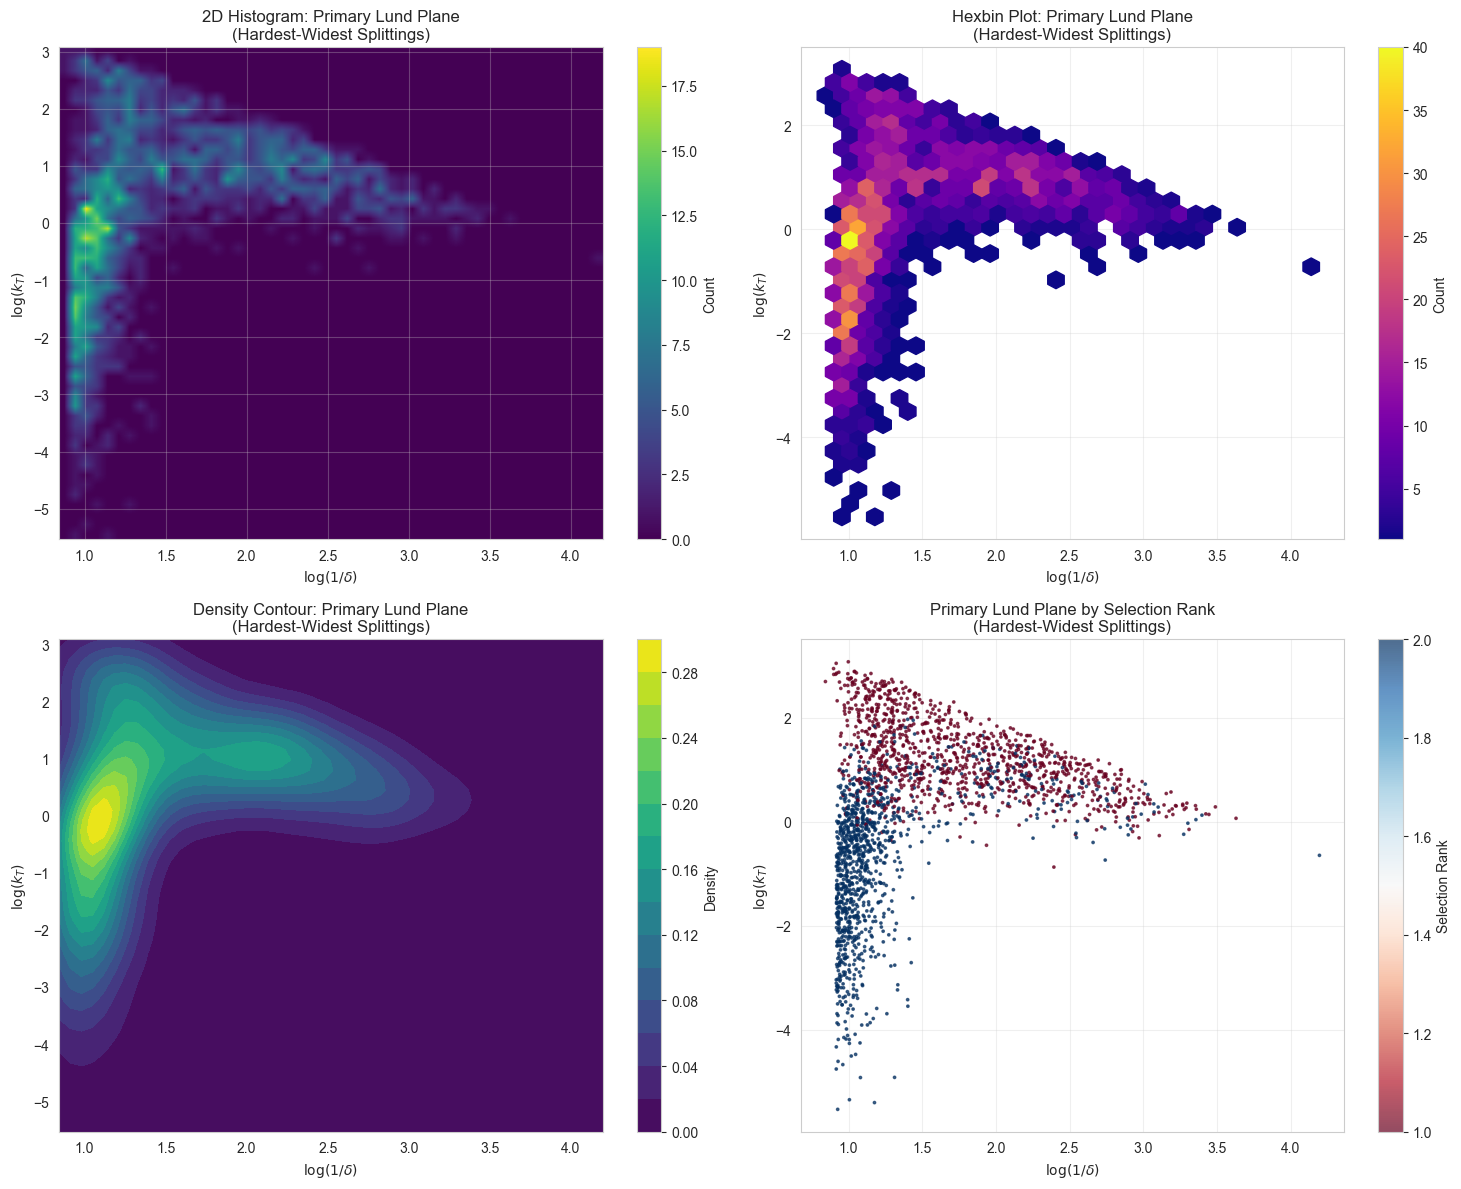

In [15]:
# First two splittings method
fig2, (lund_x_first, lund_y_first) = create_primary_lund_plane_density(
    primary_df_first, "First Two Splittings"
)
plt.show()

# Hardest-widest method
fig3, (lund_x_hw, lund_y_hw) = create_primary_lund_plane_density(
    primary_df_hw, "Hardest-Widest Splittings"
)
plt.show()

In [16]:
# Compare the different selection methods
def compare_selection_methods(primary_dfs, method_names):
    """
    Compare statistics of different selection methods
    """
    print("\\n" + "="*80)
    print("COMPARISON OF SELECTION METHODS")
    print("="*80)
    
    for df, method in zip(primary_dfs, method_names):
        valid_mask = (
            np.isfinite(df['delta']) & 
            np.isfinite(df['kt']) & 
            (df['delta'] > 0) & 
            (df['kt'] > 0)
        )
        
        filtered_df = df[valid_mask]
        
        print(f"\\n{method}:")
        print(f"  Valid splittings: {len(filtered_df):,}")
        print(f"  Jets represented: {filtered_df['jet_id'].nunique():,}")
        
        lund_x = np.log(1.0 / filtered_df['delta'])
        lund_y = np.log(filtered_df['kt'])
        
        print(f"  log(1/delta) stats: mean={np.mean(lund_x):.2f}, std={np.std(lund_x):.2f}")
        print(f"  log(k_T) stats:  mean={np.mean(lund_y):.2f}, std={np.std(lund_y):.2f}")
        print(f"  Correlation:    r={np.corrcoef(lund_x, lund_y)[0,1]:.3f}")

# Compare the methods
compare_selection_methods(
    [primary_df_kt, primary_df_first, primary_df_hw],
    ["Highest kt", "First Two", "Hardest-Widest"]
)

\n================================================================================
COMPARISON OF SELECTION METHODS
\nHighest kt:
  Valid splittings: 2,228
  Jets represented: 1,114
  log(1/delta) stats: mean=1.88, std=0.63
  log(k_T) stats:  mean=0.87, std=0.71
  Correlation:    r=-0.444
\nFirst Two:
  Valid splittings: 2,228
  Jets represented: 1,114
  log(1/delta) stats: mean=1.16, std=0.18
  log(k_T) stats:  mean=-0.51, std=1.50
  Correlation:    r=0.181
\nHardest-Widest:
  Valid splittings: 2,228
  Jets represented: 1,114
  log(1/delta) stats: mean=1.51, std=0.59
  log(k_T) stats:  mean=0.24, std=1.46
  Correlation:    r=0.321


\nCreating side-by-side comparison...
Comparison plot saved to: primary_lund_comparison.png
Comparison plot saved to: primary_lund_comparison.png


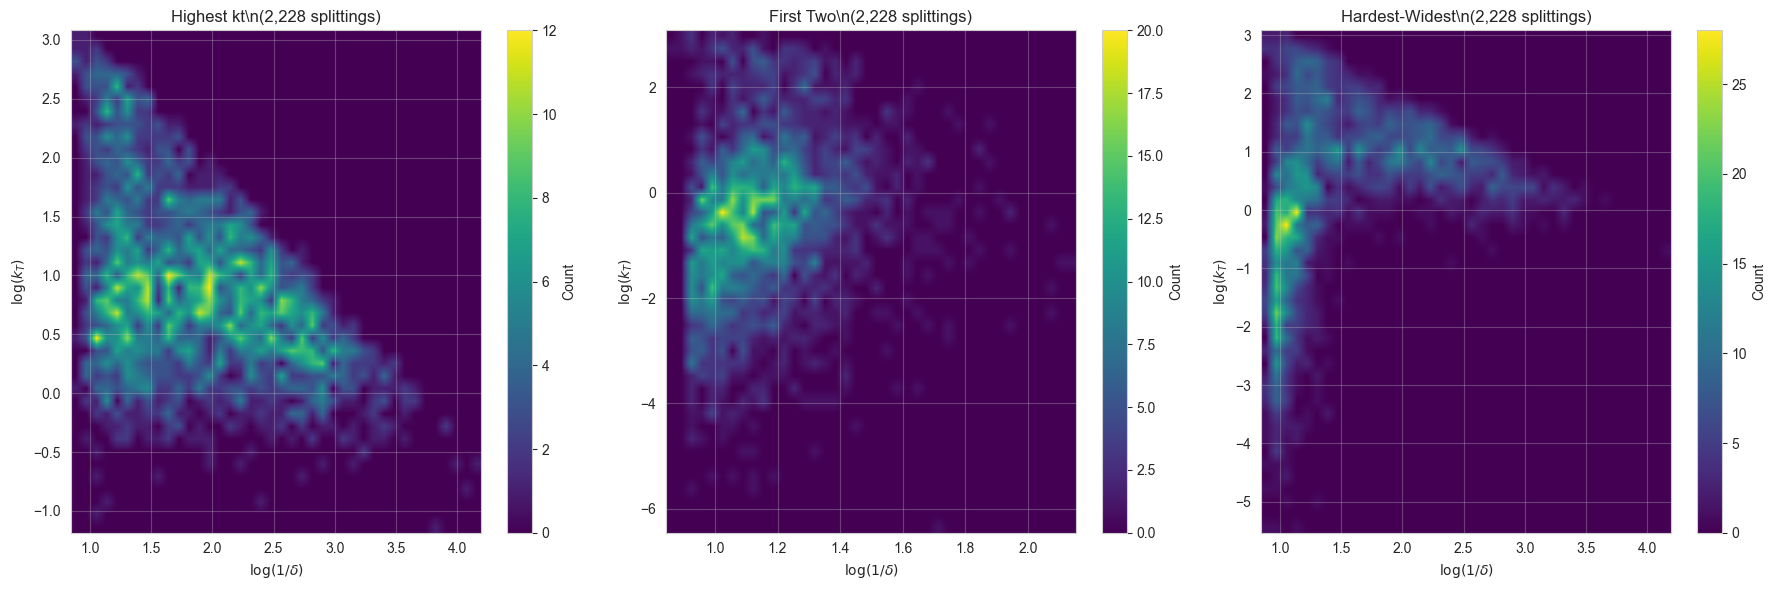

In [17]:
# Create side-by-side comparison plot
def create_comparison_plot(primary_dfs, method_names, output_file='primary_lund_comparison.png'):
    """
    Create side-by-side comparison of the three selection methods
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, (df, method) in enumerate(zip(primary_dfs, method_names)):
        # Filter valid data
        valid_mask = (
            np.isfinite(df['delta']) & 
            np.isfinite(df['kt']) & 
            (df['delta'] > 0) & 
            (df['kt'] > 0)
        )
        
        filtered_df = df[valid_mask]
        lund_x = np.log(1.0 / filtered_df['delta'])
        lund_y = np.log(filtered_df['kt'])
        
        # Create 2D histogram
        h, xedges, yedges = np.histogram2d(lund_x, lund_y, bins=40)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        
        im = axes[i].imshow(h.T, origin='lower', extent=extent, aspect='auto', 
                           cmap='viridis', interpolation='bilinear')
        
        axes[i].set_xlabel(r'$\log(1/\delta)$')
        axes[i].set_ylabel(r'$\log(k_T)$')
        axes[i].set_title(f'{method}\\n({len(filtered_df):,} splittings)')
        axes[i].grid(True, alpha=0.3)
        
        # Add colorbar
        plt.colorbar(im, ax=axes[i], label='Count')
    
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Comparison plot saved to: {output_file}")
    plt.show()

# Create the comparison plot
print("\\nCreating side-by-side comparison...")
create_comparison_plot(
    [primary_df_kt, primary_df_first, primary_df_hw],
    ["Highest kt", "First Two", "Hardest-Widest"]
)

## Average Trajectory Lund Plane

Create a Lund plane plot showing the average direction of splitting evolution from the highest-kT splitting to the second-highest kT splitting. This visualization reveals the typical flow patterns in jet substructure evolution.

In [18]:
def extract_lund_trajectories(parquet_file):
    """
    Extract Lund plane trajectories from highest-kT to second-highest kT splitting
    """
    # Read the original parquet file to maintain jet structure
    df = pd.read_parquet(parquet_file)
    
    trajectories = []
    jets_processed = 0
    
    for idx, row in df.iterrows():
        lunds = row['lunds']
        
        # Need at least 2 splittings
        if len(lunds) < 2:
            continue
            
        jets_processed += 1
        
        # Find the two splittings with highest kt
        kt_values = [(i, split.get('kt', 0)) for i, split in enumerate(lunds)]
        kt_values.sort(key=lambda x: x[1], reverse=True)
        
        highest_idx = kt_values[0][0]
        second_idx = kt_values[1][0]
        
        highest_split = lunds[highest_idx]
        second_split = lunds[second_idx]
        
        # Check if we have valid data
        if (highest_split.get('delta', 0) > 0 and highest_split.get('kt', 0) > 0 and
            second_split.get('delta', 0) > 0 and second_split.get('kt', 0) > 0):
            
            # Calculate Lund plane coordinates
            x1 = np.log(1.0 / highest_split['delta'])  # log(1/delta) for highest kT
            y1 = np.log(highest_split['kt'])           # log(kt) for highest kT
            
            x2 = np.log(1.0 / second_split['delta'])   # log(1/delta) for second highest kT
            y2 = np.log(second_split['kt'])            # log(kt) for second highest kT
            
            trajectory = {
                'jet_id': idx,
                'x1': x1, 'y1': y1,  # Start point (highest kT)
                'x2': x2, 'y2': y2,  # End point (second highest kT)
                'dx': x2 - x1,       # Direction vector x
                'dy': y2 - y1,       # Direction vector y
                'jet_pt': row['pt'],
                'jet_eta': row['eta'],
                'label': row['label']
            }
            
            trajectories.append(trajectory)
    
    print(f"Processed {jets_processed} jets, extracted {len(trajectories)} valid trajectories")
    
    return pd.DataFrame(trajectories)

# Extract trajectory data
print("Extracting Lund plane trajectories...")
trajectory_df = extract_lund_trajectories(parquet_file)

Extracting Lund plane trajectories...
Processed 1114 jets, extracted 1114 valid trajectories


Creating average trajectory Lund plane...
Created 68 average trajectory arrows from 1114 individual trajectories
Average trajectory Lund plane saved to: average_trajectory_lund_plane.png
Average trajectory Lund plane saved to: average_trajectory_lund_plane.png


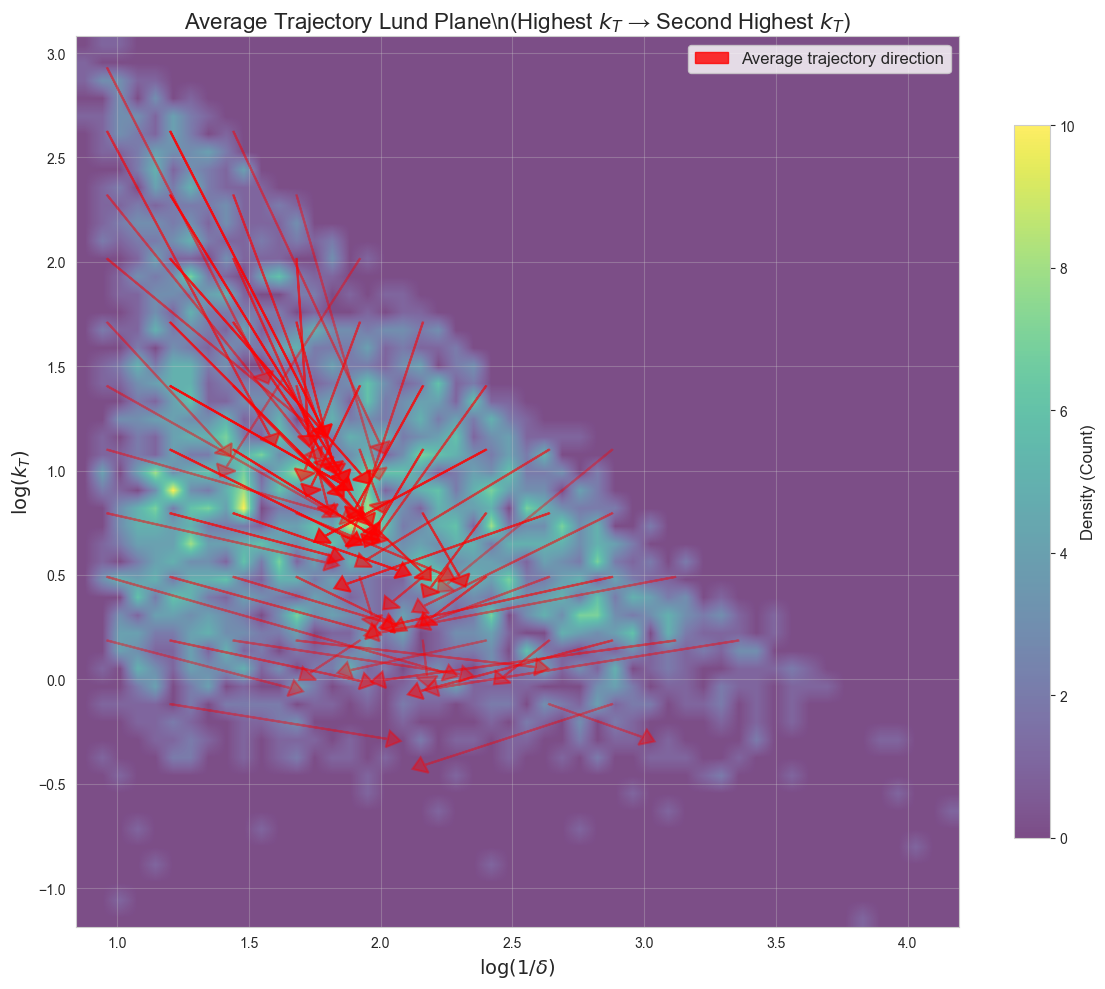

In [19]:
def create_average_trajectory_lund_plane(trajectory_df, primary_df_kt, output_file='average_trajectory_lund_plane.png'):
    """
    Create Lund plane with underlying density and average trajectory arrows
    """
    # Filter valid data for background density plot
    valid_mask = (
        np.isfinite(primary_df_kt['delta']) & 
        np.isfinite(primary_df_kt['kt']) & 
        (primary_df_kt['delta'] > 0) & 
        (primary_df_kt['kt'] > 0)
    )
    
    filtered_df = primary_df_kt[valid_mask].copy()
    lund_x = np.log(1.0 / filtered_df['delta'])
    lund_y = np.log(filtered_df['kt'])
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Create background density plot
    h, xedges, yedges = np.histogram2d(lund_x, lund_y, bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    im = ax.imshow(h.T, origin='lower', extent=extent, aspect='auto', 
                   cmap='viridis', alpha=0.7, interpolation='bilinear')
    
    # Add colorbar for density
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Density (Count)', fontsize=12)
    
    # Calculate average trajectories in grid cells
    # Define grid for averaging
    x_min, x_max = extent[0], extent[1]
    y_min, y_max = extent[2], extent[3]
    
    # Create a coarser grid for arrows (fewer than density bins)
    n_grid = 15  # Number of grid cells per axis
    x_grid = np.linspace(x_min, x_max, n_grid)
    y_grid = np.linspace(y_min, y_max, n_grid)
    
    # Calculate grid cell centers
    x_centers = (x_grid[:-1] + x_grid[1:]) / 2
    y_centers = (y_grid[:-1] + y_grid[1:]) / 2
    
    # For each grid cell, calculate average trajectory
    arrow_data = []
    
    for i, x_center in enumerate(x_centers):
        for j, y_center in enumerate(y_centers):
            # Find trajectories that start in this grid cell
            x_width = (x_grid[1] - x_grid[0]) / 2
            y_width = (y_grid[1] - y_grid[0]) / 2
            
            mask = ((trajectory_df['x1'] >= x_center - x_width) & 
                    (trajectory_df['x1'] < x_center + x_width) &
                    (trajectory_df['y1'] >= y_center - y_width) & 
                    (trajectory_df['y1'] < y_center + y_width))
            
            cell_trajectories = trajectory_df[mask]
            
            if len(cell_trajectories) >= 3:  # Minimum number for meaningful average
                avg_dx = np.mean(cell_trajectories['dx'])
                avg_dy = np.mean(cell_trajectories['dy'])
                
                # Only include if the average direction is significant
                magnitude = np.sqrt(avg_dx**2 + avg_dy**2)
                if magnitude > 0.1:  # Threshold for significance
                    arrow_data.append({
                        'x': x_center,
                        'y': y_center,
                        'dx': avg_dx,
                        'dy': avg_dy,
                        'count': len(cell_trajectories),
                        'magnitude': magnitude
                    })
    
    print(f"Created {len(arrow_data)} average trajectory arrows from {len(trajectory_df)} individual trajectories")
    
    # Plot arrows
    if arrow_data:
        arrow_df = pd.DataFrame(arrow_data)
        
        # Scale arrow lengths for visibility
        scale_factor = 0.8  # Adjust this to make arrows more/less prominent
        
        # Create arrows with color based on magnitude
        for _, arrow in arrow_df.iterrows():
            # Scale arrow length
            dx_scaled = arrow['dx'] * scale_factor
            dy_scaled = arrow['dy'] * scale_factor
            
            # Arrow color based on count (more trajectories = darker)
            alpha = min(0.9, 0.3 + 0.6 * arrow['count'] / arrow_df['count'].max())
            
            ax.arrow(arrow['x'], arrow['y'], dx_scaled, dy_scaled,
                    head_width=0.08, head_length=0.05, 
                    fc='red', ec='red', alpha=alpha, linewidth=1.5)
    
    # Customize the plot
    ax.set_xlabel(r'$\log(1/\delta)$', fontsize=14)
    ax.set_ylabel(r'$\log(k_T)$', fontsize=14)
    ax.set_title('Average Trajectory Lund Plane\\n(Highest $k_T$ → Second Highest $k_T$)', fontsize=16)
    ax.grid(True, alpha=0.3)
    
    # Add legend for arrows
    from matplotlib.patches import FancyArrowPatch
    legend_elements = [
        FancyArrowPatch((0, 0), (0.1, 0), 
                       arrowstyle='->', mutation_scale=20, 
                       color='red', alpha=0.8, 
                       label='Average trajectory direction')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Average trajectory Lund plane saved to: {output_file}")
    
    return fig, arrow_data

# Create the average trajectory plot
print("Creating average trajectory Lund plane...")
fig, arrow_data = create_average_trajectory_lund_plane(trajectory_df, primary_df_kt)
plt.show()

In [20]:
# Analyze trajectory statistics
def analyze_trajectory_statistics(trajectory_df):
    """
    Analyze the statistics of Lund plane trajectories
    """
    print("\\n" + "="*60)
    print("TRAJECTORY STATISTICS")
    print("="*60)
    
    print(f"Total valid trajectories: {len(trajectory_df):,}")
    
    # Direction statistics
    dx_mean = np.mean(trajectory_df['dx'])
    dy_mean = np.mean(trajectory_df['dy'])
    dx_std = np.std(trajectory_df['dx'])
    dy_std = np.std(trajectory_df['dy'])
    
    print(f"\\nDirection statistics:")
    print(f"  Delta-x (log(1/delta)): mean = {dx_mean:7.3f}, std = {dx_std:.3f}")
    print(f"  Delta-y (log(k_T)):  mean = {dy_mean:7.3f}, std = {dy_std:.3f}")
    
    # Magnitude and angle statistics
    magnitude = np.sqrt(trajectory_df['dx']**2 + trajectory_df['dy']**2)
    angle = np.arctan2(trajectory_df['dy'], trajectory_df['dx']) * 180 / np.pi
    
    print(f"\\nMagnitude statistics:")
    print(f"  Mean: {np.mean(magnitude):.3f}")
    print(f"  Std:  {np.std(magnitude):.3f}")
    print(f"  Min:  {np.min(magnitude):.3f}")
    print(f"  Max:  {np.max(magnitude):.3f}")
    
    print(f"\\nAngle statistics (degrees):")
    print(f"  Mean: {np.mean(angle):7.1f}°")
    print(f"  Std:  {np.std(angle):7.1f}°")
    
    # Quadrant analysis
    q1 = np.sum((trajectory_df['dx'] > 0) & (trajectory_df['dy'] > 0))  # Upper right
    q2 = np.sum((trajectory_df['dx'] < 0) & (trajectory_df['dy'] > 0))  # Upper left
    q3 = np.sum((trajectory_df['dx'] < 0) & (trajectory_df['dy'] < 0))  # Lower left
    q4 = np.sum((trajectory_df['dx'] > 0) & (trajectory_df['dy'] < 0))  # Lower right
    
    print(f"\\nQuadrant analysis:")
    print(f"  Q1 (→↑): {q1:5,} ({100*q1/len(trajectory_df):5.1f}%) - Wider angle, higher k_T")
    print(f"  Q2 (←↑): {q2:5,} ({100*q2/len(trajectory_df):5.1f}%) - Narrower angle, higher k_T")
    print(f"  Q3 (←↓): {q3:5,} ({100*q3/len(trajectory_df):5.1f}%) - Narrower angle, lower k_T")
    print(f"  Q4 (→↓): {q4:5,} ({100*q4/len(trajectory_df):5.1f}%) - Wider angle, lower k_T")
    
    return {
        'magnitude': magnitude,
        'angle': angle,
        'dx_mean': dx_mean,
        'dy_mean': dy_mean
    }

# Analyze trajectory statistics
trajectory_stats = analyze_trajectory_statistics(trajectory_df)

\n============================================================
TRAJECTORY STATISTICS
Total valid trajectories: 1,114
\nDirection statistics:
  Delta-x (log(1/delta)): mean =   0.218, std = 0.909
  Delta-y (log(k_T)):  mean =  -0.717, std = 0.625
\nMagnitude statistics:
  Mean: 1.178
  Std:  0.624
  Min:  0.024
  Max:  3.829
\nAngle statistics (degrees):
  Mean:   -81.2°
  Std:     55.1°
\nQuadrant analysis:
  Q1 (→↑):     0 (  0.0%) - Wider angle, higher k_T
  Q2 (←↑):     0 (  0.0%) - Narrower angle, higher k_T
  Q3 (←↓):   429 ( 38.5%) - Narrower angle, lower k_T
  Q4 (→↓):   685 ( 61.5%) - Wider angle, lower k_T


\nCreating trajectory analysis plots...
Trajectory analysis plots saved to: trajectory_analysis.png
Trajectory analysis plots saved to: trajectory_analysis.png


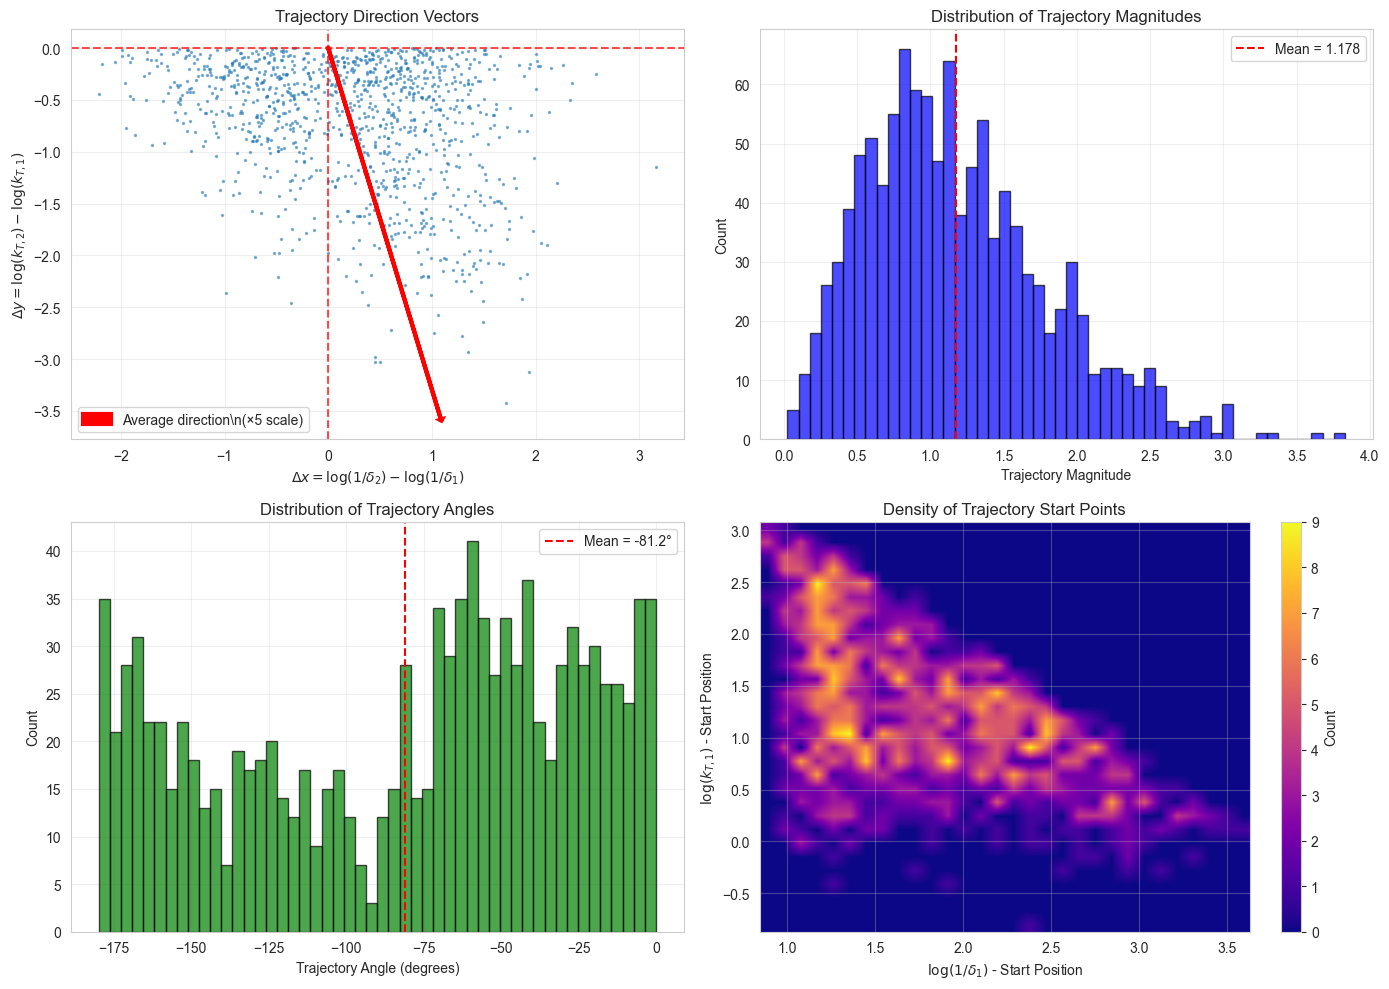

In [21]:
# Create supplementary plots for trajectory analysis
def create_trajectory_analysis_plots(trajectory_df, trajectory_stats, output_file='trajectory_analysis.png'):
    """
    Create supplementary plots showing trajectory distributions
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Direction vector plot
    axes[0, 0].scatter(trajectory_df['dx'], trajectory_df['dy'], alpha=0.5, s=2)
    axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7)
    axes[0, 0].set_xlabel(r'$\Delta x = \log(1/\delta_2) - \log(1/\delta_1)$')
    axes[0, 0].set_ylabel(r'$\Delta y = \log(k_{T,2}) - \log(k_{T,1})$')
    axes[0, 0].set_title('Trajectory Direction Vectors')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add average direction arrow
    axes[0, 0].arrow(0, 0, trajectory_stats['dx_mean']*5, trajectory_stats['dy_mean']*5,
                    head_width=0.02, head_length=0.01, fc='red', ec='red', linewidth=3,
                    label=f'Average direction\\n(×5 scale)')
    axes[0, 0].legend()
    
    # Magnitude distribution
    axes[0, 1].hist(trajectory_stats['magnitude'], bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 1].axvline(x=np.mean(trajectory_stats['magnitude']), color='red', linestyle='--', 
                      label=f'Mean = {np.mean(trajectory_stats["magnitude"]):.3f}')
    axes[0, 1].set_xlabel('Trajectory Magnitude')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('Distribution of Trajectory Magnitudes')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    
    # Angle distribution
    axes[1, 0].hist(trajectory_stats['angle'], bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[1, 0].axvline(x=np.mean(trajectory_stats['angle']), color='red', linestyle='--',
                      label=f'Mean = {np.mean(trajectory_stats["angle"]):.1f}°')
    axes[1, 0].set_xlabel('Trajectory Angle (degrees)')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title('Distribution of Trajectory Angles')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    
    # Start position density
    h, xedges, yedges = np.histogram2d(trajectory_df['x1'], trajectory_df['y1'], bins=30)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = axes[1, 1].imshow(h.T, origin='lower', extent=extent, aspect='auto', 
                          cmap='plasma', interpolation='bilinear')
    axes[1, 1].set_xlabel(r'$\log(1/\delta_1)$ - Start Position')
    axes[1, 1].set_ylabel(r'$\log(k_{T,1})$ - Start Position')
    axes[1, 1].set_title('Density of Trajectory Start Points')
    axes[1, 1].grid(True, alpha=0.3)
    plt.colorbar(im, ax=axes[1, 1], label='Count')
    
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Trajectory analysis plots saved to: {output_file}")
    plt.show()

# Create trajectory analysis plots
print("\\nCreating trajectory analysis plots...")
create_trajectory_analysis_plots(trajectory_df, trajectory_stats)